# 5-4 Self-Attention GAN の学習・生成の実装

## Self-Attention モジュールの実装
モジュールへの入力 $x$，Self-Attention Map が $o$ のとき出力は次で与えられる．
$$
    y = x + \gamma o
$$
この係数 $\gamma$ は学習させる値である．

In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import transforms

%matplotlib inline

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
class Self_Attention(nn.Module):
    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()
        
        # 1x1 の畳み込み層による pointwise convolution を用意
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        
        # Attention Map 作成時の規格化 Softmax
        self.softmax = nn.Softmax(dim=-2)
        
        # 元の入力と Self-Attention を足し合わせるための係数
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        # 入力変数
        X = x
        
        # 畳み込みしてからサイズを変形する（BxC'xWxH => BxC'xN）
        proj_query = self.query_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3])
        proj_query = proj_query.permute(0, 2, 1)
        proj_key = self.key_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3])
        
        # 掛け算
        S = torch.bmm(proj_query, proj_key)

        # 規格
        attention_map_T = self.softmax(S)
        attention_map = attention_map_T.permute(0, 2, 1)

        # Self-Atttention Map を計算
        proj_value = self.value_conv(X).view(X.shape[0], -1, X.shape[2] * X.shape[3])
        o = torch.bmm(proj_value, attention_map.permute(0, 2, 1))
        
        # o と x のテンソルサイズを揃えて出力
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x + self.gamma * o
        
        return out, attention_map

## 生成器 Generator の実装
DCGAN からの変更点は次の通り．

1. last layer 以外に Spectral Normalization を追加
1. layer3 と layer4 の間と layer4 と last の間に Self-Attention モジュールを追加

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1)), 
                                    nn.BatchNorm2d(image_size * 8),
                                    nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1)), 
                                    nn.BatchNorm2d(image_size * 4),
                                    nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1)),
                                    nn.BatchNorm2d(image_size * 2), 
                                    nn.ReLU(inplace=True))
        
        self.self_attention1 = Self_Attention(in_dim=image_size * 2)
        
        self.layer4 = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1)),
                                    nn.BatchNorm2d(image_size),
                                    nn.ReLU(inplace=True))
        
        self.self_attention2 = Self_Attention(in_dim=image_size)
        
        self.last = nn.Sequential(nn.utils.spectral_norm(nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1)), 
                                  nn.Tanh())
    
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

## 識別器 Discriminator の実装
DCGAN からの変更点は次の通り．

1. last layer 以外に Spectral Normalization を追加
1. layer3 と layer4 の間と layer4 と last の間に Self-Attention モジュールを追加

In [4]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)), 
                                    nn.LeakyReLU(0.1, inplace=True))
        self.layer2 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(image_size, image_size * 2, kernel_size=4, stride=2, padding=1)), 
                                    nn.LeakyReLU(0.1, inplace=True))
        self.layer3 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(image_size * 2, image_size * 4, kernel_size=4, stride=2, padding=1)), 
                                    nn.LeakyReLU(0.1, inplace=True))
        
        self.self_attention1 = Self_Attention(in_dim=image_size * 4)
        
        self.layer4 = nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(image_size * 4, image_size * 8, kernel_size=4, stride=2, padding=1)), 
                                    nn.LeakyReLU(0.1, inplace=True))
        
        self.self_attention2 = Self_Attention(in_dim=image_size * 8)
        
        self.last = nn.Conv2d(image_size * 8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attention1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attention2(out)
        out = self.last(out)
        
        return out, attention_map1, attention_map2

## DataLoader の作成
ここでは，5.2節と同じものを使う．

In [5]:
def make_datapath_list():
    """ 学習・検証の画像データとアノテーションデータへのファイルパスリストを作成する """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
    
    
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed

## ネットワークの初期化と学習の実施
DCGAN の損失関数は D の出力を $y=D(x)$ として次で与えられる．
$$
    - \sum_{i=1}^{M} [l_i log y_i + (1 - l_i) log (1 - y_i)]
$$

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="mean")
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

SAGAN の損失関数は次式で定義される hinge version of the adversarial loss を用いる．
$$
    - \frac{1}{M} \sum_{i=1}^{M}[l_i * min(0, -1 + y_i) + (1 - l_i) * min(0, -1 - y_i)]
$$
これは次のように ReLU 関数を使って実装できる．

In [ ]:
d_loss_real = nn.ReLU()(1.0 - d_out_real).mean()
d_loss_fake = nn.ReLU()(1.0 + d_out_fake).mean()

DCGAN では生成器 G の損失関数は次のように与えられる．
$$
    -\sum_{i=1}^{M}logD(G(z_i))
$$

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction='mean')
g_loss = criterion(d_out_fake.view(-1), label_real)

SAGAN の G の損失関数は次のように与えられる．
$$
    - \frac{1}{M} \sum_{i=1}^{M}D(G(z_i))
$$

In [ ]:
g_loss = -d_out_fake.mean()

上記のような損失関数は，数学的な根拠があるわけではなく経験的に学習がうまくいくという理由で選ばれている．

In [6]:
def train_model(G, D, dataloader, num_epochs):
    # GPU が使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(" 使用デバイス:", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    
    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64
    
    # ネットワークを GPU へ
    G.to(device)
    D.to(device)
    
    # モデルを訓練モードに
    G.train()
    D.train()
    
    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    
    # epoch のループ
    for epoch in range(num_epochs):
        # epoch の損失和
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        # 時間の計測
        t_epoch_start = time.time()
        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')
        
        # データローダーから minibatch ずつ取り出すループ
        for imges in dataloader:
            # -----------------------
            # 1. Discriminator の学習
            # -----------------------
            if imges.size()[0] == 1:
                continue
            
            # GPU が使えるなら GPU にデータを送る
            imges = imges.to(device)
            
            # 正解ラベルと偽ラベルを作成
            # epoch の最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            
            # 真の画像を判定
            d_out_real, _, _ = D(imges)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差を計算
            d_loss_real = nn.ReLU()(1.0 - d_out_real).mean()
            d_loss_fake = nn.ReLU()(1.0 + d_out_fake).mean()
            d_loss = d_loss_real + d_loss_fake
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # -------------------
            # 2. Generator の学習
            # -------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)
            
            # 誤差を計算
            g_loss = - d_out_fake.mean()
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
            
        # epoch の phase ごとの loss と正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
    
    return G, D

In [7]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d と ConvTranspose2d の初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d の初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
# ファイルのパスリストを作成
train_img_list = make_datapath_list()

# Dataset を作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# Dataloader を作成
batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)  # イテレータに変換
            
# 初期化の実行
G = Generator()
G.apply(weights_init)
D = Discriminator()
D.apply(weights_init)
print(" ネットワークの初期化完了 ")

# 学習・検証を実行する
num_epochs = 300
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

 ネットワークの初期化完了 
 使用デバイス: cuda:0
-------------
Epoch 0/300
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.0944 ||Epoch_G_Loss:0.1426
timer: 2.3799 sec.
-------------
Epoch 1/300
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.0146 ||Epoch_G_Loss:0.1856
timer: 2.3037 sec.
-------------
Epoch 2/300
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.2005 ||Epoch_G_Loss:0.1685
timer: 2.3054 sec.
-------------
Epoch 3/300
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0853 ||Epoch_G_Loss:0.0390
timer: 2.3414 sec.
-------------
Epoch 4/300
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.0643 ||Epoch_G_Loss:0.0862
timer: 2.3219 sec.
-------------
Epoch 5/300
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0510 ||Epoch_G_Loss:0.0977
timer: 2.3207 sec.
-------------
Epoch 6/300
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.0011 ||Epoch_G_Loss:0.1330
timer: 2.3225 sec.
-------------
Epoch 7/300
-----

-------------
epoch 60 || Epoch_D_Loss:0.1350 ||Epoch_G_Loss:0.0711
timer: 2.3393 sec.
-------------
Epoch 61/300
-------------
(train)
-------------
epoch 61 || Epoch_D_Loss:0.1381 ||Epoch_G_Loss:0.0579
timer: 2.3458 sec.
-------------
Epoch 62/300
-------------
(train)
-------------
epoch 62 || Epoch_D_Loss:0.1380 ||Epoch_G_Loss:0.0597
timer: 2.3429 sec.
-------------
Epoch 63/300
-------------
(train)
-------------
epoch 63 || Epoch_D_Loss:0.1380 ||Epoch_G_Loss:0.0739
timer: 2.3463 sec.
-------------
Epoch 64/300
-------------
(train)
-------------
epoch 64 || Epoch_D_Loss:0.1507 ||Epoch_G_Loss:0.0676
timer: 2.3432 sec.
-------------
Epoch 65/300
-------------
(train)
-------------
epoch 65 || Epoch_D_Loss:0.1284 ||Epoch_G_Loss:0.0942
timer: 2.3461 sec.
-------------
Epoch 66/300
-------------
(train)
-------------
epoch 66 || Epoch_D_Loss:0.1411 ||Epoch_G_Loss:0.0652
timer: 2.3433 sec.
-------------
Epoch 67/300
-------------
(train)
-------------
epoch 67 || Epoch_D_Loss:0.1371 ||

-------------
epoch 120 || Epoch_D_Loss:0.1046 ||Epoch_G_Loss:0.0964
timer: 2.3527 sec.
-------------
Epoch 121/300
-------------
(train)
-------------
epoch 121 || Epoch_D_Loss:0.1104 ||Epoch_G_Loss:0.0736
timer: 2.3482 sec.
-------------
Epoch 122/300
-------------
(train)
-------------
epoch 122 || Epoch_D_Loss:0.1160 ||Epoch_G_Loss:0.0839
timer: 2.3493 sec.
-------------
Epoch 123/300
-------------
(train)
-------------
epoch 123 || Epoch_D_Loss:0.1135 ||Epoch_G_Loss:0.0892
timer: 2.3541 sec.
-------------
Epoch 124/300
-------------
(train)
-------------
epoch 124 || Epoch_D_Loss:0.0965 ||Epoch_G_Loss:0.0884
timer: 2.3437 sec.
-------------
Epoch 125/300
-------------
(train)
-------------
epoch 125 || Epoch_D_Loss:0.0996 ||Epoch_G_Loss:0.1192
timer: 2.3520 sec.
-------------
Epoch 126/300
-------------
(train)
-------------
epoch 126 || Epoch_D_Loss:0.1046 ||Epoch_G_Loss:0.0786
timer: 2.3498 sec.
-------------
Epoch 127/300
-------------
(train)
-------------
epoch 127 || Epoch_D

-------------
epoch 180 || Epoch_D_Loss:0.0617 ||Epoch_G_Loss:0.1250
timer: 2.3515 sec.
-------------
Epoch 181/300
-------------
(train)
-------------
epoch 181 || Epoch_D_Loss:0.0728 ||Epoch_G_Loss:0.1263
timer: 2.3464 sec.
-------------
Epoch 182/300
-------------
(train)
-------------
epoch 182 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.1505
timer: 2.3484 sec.
-------------
Epoch 183/300
-------------
(train)
-------------
epoch 183 || Epoch_D_Loss:0.0631 ||Epoch_G_Loss:0.1277
timer: 2.3463 sec.
-------------
Epoch 184/300
-------------
(train)
-------------
epoch 184 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.1402
timer: 2.3493 sec.
-------------
Epoch 185/300
-------------
(train)
-------------
epoch 185 || Epoch_D_Loss:0.0673 ||Epoch_G_Loss:0.1316
timer: 2.3453 sec.
-------------
Epoch 186/300
-------------
(train)
-------------
epoch 186 || Epoch_D_Loss:0.0685 ||Epoch_G_Loss:0.1418
timer: 2.3456 sec.
-------------
Epoch 187/300
-------------
(train)
-------------
epoch 187 || Epoch_D

-------------
epoch 240 || Epoch_D_Loss:0.0282 ||Epoch_G_Loss:0.1952
timer: 2.3492 sec.
-------------
Epoch 241/300
-------------
(train)
-------------
epoch 241 || Epoch_D_Loss:0.0444 ||Epoch_G_Loss:0.1949
timer: 2.3486 sec.
-------------
Epoch 242/300
-------------
(train)
-------------
epoch 242 || Epoch_D_Loss:0.0317 ||Epoch_G_Loss:0.1847
timer: 2.3506 sec.
-------------
Epoch 243/300
-------------
(train)
-------------
epoch 243 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.1677
timer: 2.3487 sec.
-------------
Epoch 244/300
-------------
(train)
-------------
epoch 244 || Epoch_D_Loss:0.0353 ||Epoch_G_Loss:0.1860
timer: 2.3493 sec.
-------------
Epoch 245/300
-------------
(train)
-------------
epoch 245 || Epoch_D_Loss:0.0471 ||Epoch_G_Loss:0.1717
timer: 2.3463 sec.
-------------
Epoch 246/300
-------------
(train)
-------------
epoch 246 || Epoch_D_Loss:0.0337 ||Epoch_G_Loss:0.2033
timer: 2.3529 sec.
-------------
Epoch 247/300
-------------
(train)
-------------
epoch 247 || Epoch_D

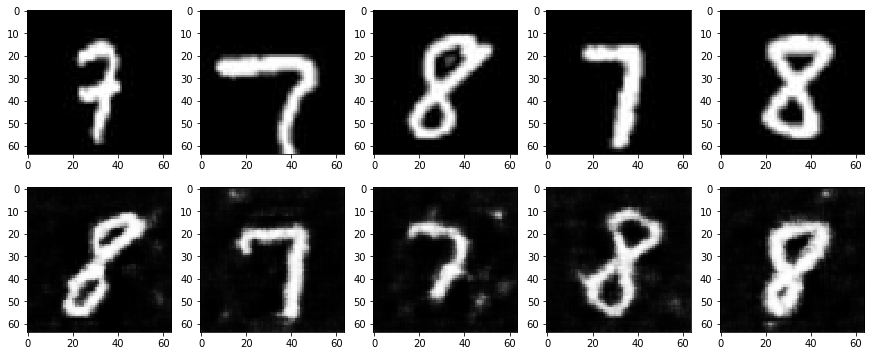

In [10]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader) # イテレータに変換
imges = next(batch_iterator) # 1 番目の要素を取り出す

# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')
    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

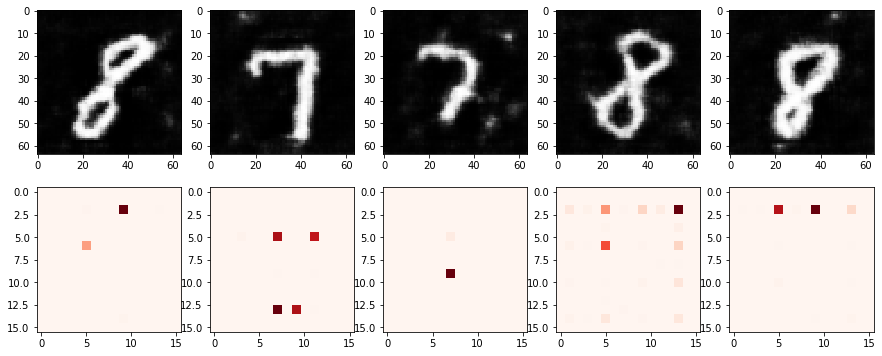

In [13]:
# Attentiom Map を出力
fig = plt.figure(figsize=(15, 6))

for i in range(0, 5):
    # 上段に生成した画像データを
    plt.subplot(2, 5, i + 1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')
    # 下段に Attentin Map1 の画像中央のピクセルのデータを
    plt.subplot(2, 5, 5 + i + 1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7] # 中央に着目
    plt.imshow(am.cpu().detach().numpy(), 'Reds')

Attention Map は画像キャンバスの縦横方向中央にあるど真ん中のピクセルを生成する際に，他のどの位置のピクセルの特徴量に Attention をかけて考慮したのかを示している．